# Text-to-Image Generation with Stable Diffusion and OpenVINO™

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It is trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

General diffusion models are machine learning systems that are trained to denoise random gaussian noise step by step, to get to a sample of interest, such as an image.
Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference. OpenVINO brings capabilities to run model inference on Intel hardware and opens the door to the fantastic world of diffusion models for everyone!

Model capabilities are not limited text-to-image only, it also is able solve additional tasks, for example text-guided image-to-image generation and inpainting. This tutorial also considers how to run text-guided image-to-image generation using Stable Diffusion.


This notebook demonstrates how to convert and run stable diffusion model using OpenVINO.

Notebook contains the following steps:

1. Download and convert the model from a public source using the [OpenVINO integration with Hugging Face Optimum](https://huggingface.co/blog/openvino).
2. Create a text-to-image inference pipeline
3. Create a image-to-image inference pipeline
3. Run Stable Diffusion pipeline with OpenVINO.


#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Prepare Inference Pipeline](#Prepare-Inference-Pipeline)
    - [Load Stable Diffusion model and create text-to-image pipeline](#Load-Stable-Diffusion-model-and-create-text-to-image-pipeline)
    - [Text-to-Image generation](#Text-to-Image-generation)
    - [Create image-to-Image pipeline](#Create-image-to-Image-pipeline)
    - [Image-to-Image generation](#Image-to-Image-generation)
- [Interactive demo](#Interactive-demo)



## Prerequisites
[back to top ⬆️](#Table-of-contents:)

**The following is needed only if you want to use the original model. If not, you do not have to do anything. Just run the notebook.**

>**Note**:
>The original model (for example, `stable-diffusion-v1-4`) requires you to accept the model license before downloading or using its weights. Visit the [stable-diffusion-v1-4 card](https://huggingface.co/CompVis/stable-diffusion-v1-4) to read and accept the license before you proceed.
>To use this diffusion model, you must be a registered user in 🤗 Hugging Face Hub. You will need to use an access token for the code below to run. For more information on access tokens, refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on Hugging Face Hub in notebook environment, using following code:
```python

# login to huggingfacehub to get access to pretrained model
[back to top ⬆️](#Table-of-contents:)

from huggingface_hub import notebook_login, whoami

try:
    whoami()
    print('Authorization token already provided')
except OSError:
    notebook_login()
```

This tutorial uses a Stable Diffusion model, fine-tuned using images from Midjourney v4 (another popular solution for text to image generation).
You can find more details about this model on the [model card](https://huggingface.co/prompthero/openjourney). The same steps for conversion and running the pipeline are applicable to other solutions based on Stable Diffusion.


In [1]:
%pip install -q "openvino>=2023.1.0" "git+https://github.com/huggingface/optimum-intel.git"
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "diffusers>=0.9.0" "torch>=2.1"
%pip install -q "huggingface-hub>=0.9.1"
%pip install -q "gradio>=4.19"
%pip install -q transformers Pillow opencv-python tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Prepare Inference Pipeline
[back to top ⬆️](#Table-of-contents:)

Let us now take a closer look at how the model works in inference by illustrating the logical flow.

![sd-pipeline](https://user-images.githubusercontent.com/29454499/260981188-c112dd0a-5752-4515-adca-8b09bea5d14a.png)

As you can see from the diagram, the only difference between Text-to-Image and text-guided Image-to-Image generation in approach is how initial latent state is generated. In case of Image-to-Image generation, you additionally have an image encoded by VAE encoder mixed with the noise produced by using latent seed, while in Text-to-Image you use only noise as initial latent state.
The stable diffusion model takes both a latent image representation of size $64 \times 64$ and a text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder as an input.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, it is recommended to use one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)(you will use it in your pipeline)

Theory on how the scheduler algorithm function works is out of scope for this notebook. Nonetheless, in short, you should remember that you compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, refer to the recommended [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated given number of times (by default 50) to step-by-step retrieve better latent image representations.
When complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

### Load Stable Diffusion model and create text-to-image pipeline
[back to top ⬆️](#Table-of-contents:)

We will load optimized Stable Diffusion model from the Hugging Face Hub and create pipeline to run an inference with OpenVINO Runtime by [Optimum Intel](https://huggingface.co/docs/optimum/intel/inference). 

For running the Stable Diffusion model with Optimum Intel, we will use the `optimum.intel.OVStableDiffusionPipeline` class, which represents the inference pipeline. `OVStableDiffusionPipeline` initialized by the `from_pretrained` method. It supports on-the-fly conversion models from PyTorch using the `export=True` parameter. A converted model can be saved on disk using the `save_pretrained` method for the next running.

When Stable Diffusion models are exported to the OpenVINO format, they are decomposed into three components that consist of four models combined during inference into the pipeline:

* The text encoder
    * The text-encoder is responsible for transforming the input prompt(for example "a photo of an astronaut riding a horse") into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.
* The U-NET
    * Model predicts the `sample` state for the next step.
* The VAE encoder
    * The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model.
* The VAE decoder
    * The decoder transforms the latent representation back into an image.

More details about the Stable Diffusion pipeline can be found in [stable-diffusion](../stable-diffusion-text-to-image/stable-diffusion-text-to-image.ipynb) notebook.

Select device from dropdown list for running inference using OpenVINO.

In [1]:
import ipywidgets as widgets
import openvino as ov

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [2]:
from optimum.intel.openvino import OVStableDiffusionPipeline
from pathlib import Path

DEVICE = device.value

MODEL_ID = "prompthero/openjourney"
MODEL_DIR = Path("diffusion_pipeline")

if not MODEL_DIR.exists():
    ov_pipe = OVStableDiffusionPipeline.from_pretrained(MODEL_ID, export=True, device=DEVICE, compile=False)
    ov_pipe.save_pretrained(MODEL_DIR)
else:
    ov_pipe = OVStableDiffusionPipeline.from_pretrained(MODEL_DIR, device=DEVICE, compile=False)

ov_pipe.compile()

Compiling the vae_decoder to CPU ...
Compiling the unet to CPU ...
Compiling the text_encoder to CPU ...
Compiling the vae_encoder to CPU ...


### Text-to-Image generation
[back to top ⬆️](#Table-of-contents:)

Now, you can define a text prompt for image generation and run inference pipeline.

> **Note**: Consider increasing `steps` to get more precise results. A suggested value is `50`, but it will take longer time to process.

In [3]:
import ipywidgets as widgets

sample_text = (
    "cyberpunk cityscape like Tokyo New York  with tall buildings at dusk golden hour cinematic lighting, epic composition. "
    "A golden daylight, hyper-realistic environment. "
    "Hyper and intricate detail, photo-realistic. "
    "Cinematic and volumetric light. "
    "Epic concept art. "
    "Octane render and Unreal Engine, trending on artstation"
)
text_prompt = widgets.Text(value=sample_text, description="your text")
num_steps = widgets.IntSlider(min=1, max=50, value=20, description="steps:")
widgets.VBox([text_prompt, num_steps])

In [4]:
print("Pipeline settings")
print(f"Input text: {text_prompt.value}")
print(f"Number of steps: {num_steps.value}")

Pipeline settings
Input text: cyberpunk cityscape like Tokyo New York  with tall buildings at dusk golden hour cinematic lighting, epic composition. A golden daylight, hyper-realistic environment. Hyper and intricate detail, photo-realistic. Cinematic and volumetric light. Epic concept art. Octane render and Unreal Engine, trending on artstation
Number of steps: 20


In [5]:
result = ov_pipe(text_prompt.value, num_inference_steps=num_steps.value)

  0%|          | 0/21 [00:00<?, ?it/s]

Finally, let us save generation results.
The pipeline returns several results: `sample` contains final generated image, `iterations` contains list of intermediate results for each step.

In [6]:
final_image = result["images"][0]
if "iterations" in result:
    all_frames = result["iterations"]
    img = next(iter(all_frames))
    img.save(
        fp="result.gif",
        format="GIF",
        append_images=iter(all_frames),
        save_all=True,
        duration=len(all_frames) * 5,
        loop=0,
    )
final_image.save("result.png")

Now is show time!

Input text:
	cyberpunk cityscape like Tokyo New York  with tall buildings at dusk golden hour cinematic lighting, epic composition
	 A golden daylight, hyper-realistic environment
	 Hyper and intricate detail, photo-realistic
	 Cinematic and volumetric light
	 Epic concept art
	 Octane render and Unreal Engine, trending on artstation


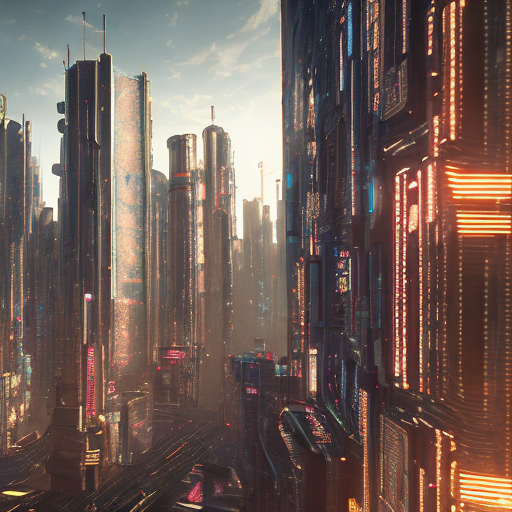

In [7]:
import ipywidgets as widgets

text = "\n\t".join(text_prompt.value.split("."))
print("Input text:")
print("\t" + text)
display(final_image)

Nice. As you can see, the picture has quite a high definition 🔥.

### Create image-to-Image pipeline
[back to top ⬆️](#Table-of-contents:)

For running the Stable Diffusion model with Optimum Intel, we will use the `optimum.intel.OVStableDiffusionImg2ImgPipeline` class, which represents the inference pipeline.

In [8]:
from optimum.intel.openvino import OVStableDiffusionImg2ImgPipeline

if not MODEL_DIR.exists():
    ov_pipe_i2i = OVStableDiffusionImg2ImgPipeline.from_pretrained(MODEL_ID, export=True, device=DEVICE, compile=False)
    ov_pipe_i2i.save_pretrained(MODEL_DIR)
else:
    ov_pipe_i2i = OVStableDiffusionImg2ImgPipeline.from_pretrained(MODEL_DIR, device=DEVICE, compile=False)

ov_pipe_i2i.compile()

Compiling the vae_decoder to CPU ...
Compiling the unet to CPU ...
Compiling the vae_encoder to CPU ...
Compiling the text_encoder to CPU ...


### Image-to-Image generation
[back to top ⬆️](#Table-of-contents:)

Image-to-Image generation, additionally to text prompt, requires providing initial image. Optionally, you can also change `strength` parameter, which is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 enable lots of variations but will also produce images that are not semantically consistent with the input.

In [9]:
text_prompt_i2i = widgets.Text(value="amazing watercolor painting", description="your text")
num_steps_i2i = widgets.IntSlider(min=1, max=50, value=10, description="steps:")
image_widget = widgets.FileUpload(
    accept="",
    multiple=False,
    description="Upload image",
)
strength = widgets.FloatSlider(min=0, max=1, description="strength: ", value=0.5)
widgets.VBox([text_prompt_i2i, num_steps_i2i, image_widget, strength])

In [10]:
# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

'coco.jpg' already exists.
Pipeline settings
Input text: amazing watercolor painting
Number of steps: 10
Strength: 0.5
Input image:


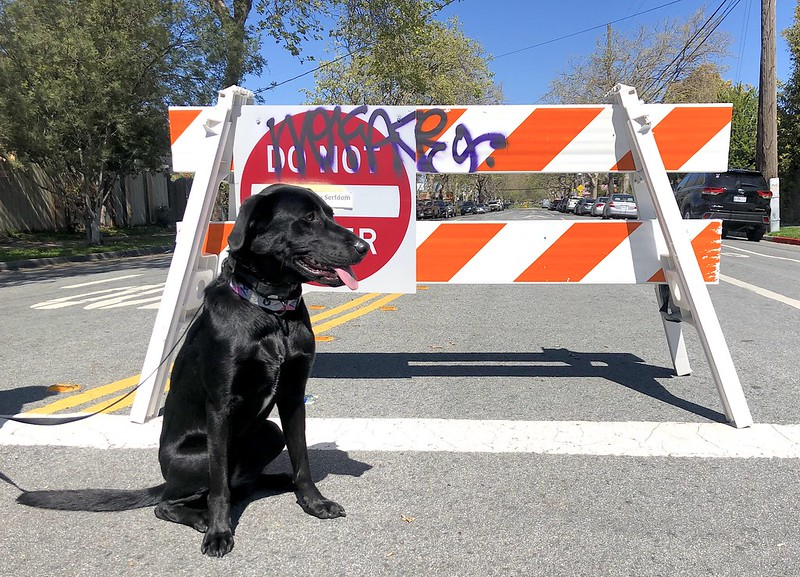

In [11]:
import io
import PIL
default_image_path = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    filename="coco.jpg",
)

# read uploaded image
image = PIL.Image.open(io.BytesIO(image_widget.value[-1]["content"]) if image_widget.value else str(default_image_path))
print("Pipeline settings")
print(f"Input text: {text_prompt_i2i.value}")
print(f"Number of steps: {num_steps_i2i.value}")
print(f"Strength: {strength.value}")
print("Input image:")
display(image)

In [12]:
import PIL
import numpy as np

def scale_fit_to_window(dst_width: int, dst_height: int, image_width: int, image_height: int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio
    and fitting image to specific window size

    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: PIL.Image.Image):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1].
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.

    Parameters:
      image (PIL.Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       meta (Dict): dictionary with preprocessing metadata info
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(512, 512, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height), resample=PIL.Image.Resampling.LANCZOS))[None, :]
    pad_width = 512 - dst_width
    pad_height = 512 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = 2.0 * image - 1.0
    return image, {"padding": pad, "src_width": src_width, "src_height": src_height}


def postprocess(image: PIL.Image.Image, orig_width: int, orig_height: int):
    """
    Image postprocessing function. Takes image in PIL.Image format and metrics of original image. Image is cropped and resized to restore initial size.

    Parameters:
      image (PIL.Image.Image): input image
      orig_width (int): original image width
      orig_height (int): original image height
    Returns:
       image (PIL.Image.Image): postprocess image
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(src_width, src_height, orig_width, orig_height)
    image = image.crop((0, 0, dst_width, dst_height))
    image = image.resize((orig_width, orig_height))
    return image

In [17]:
preprocessed_image, meta_data = preprocess(image)

processed_image = ov_pipe_i2i(
    text_prompt_i2i.value,
    preprocessed_image,
    num_inference_steps=num_steps_i2i.value,
    strength=strength.value
)

  0%|          | 0/10 [00:00<?, ?steps/s]

In [18]:
final_image_i2i = postprocess(processed_image["images"][0], meta_data['src_width'], meta_data['src_height'])
if "iterations" in processed_image:
    all_frames_i2i = processed_image["iterations"]
    img = next(iter(all_frames_i2i))
    img = postprocess(img, meta_data['src_width'], meta_data['src_height'])
    img.save(
        fp="result_i2i.gif",
        format="GIF",
        append_images=iter(all_frames_i2i),
        save_all=True,
        duration=len(all_frames_i2i) * 5,
        loop=0,
    )
final_image_i2i.save("result_i2i.png")

Input text:
	amazing watercolor painting


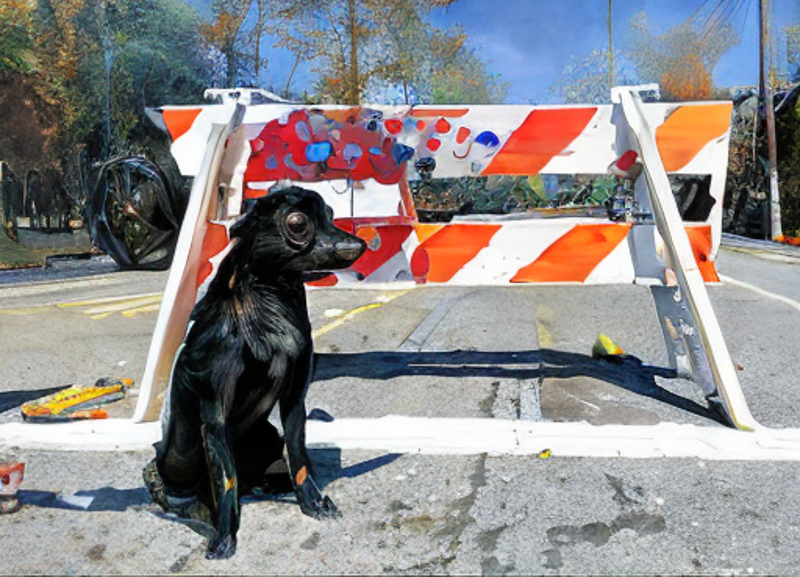

In [19]:
text_i2i = "\n\t".join(text_prompt_i2i.value.split("."))
print("Input text:")
print("\t" + text_i2i)
display(final_image_i2i)

## Interactive demo
[back to top ⬆️](#Table-of-contents:)


In [16]:
import gradio as gr


def generate_from_text(text, num_steps, _=gr.Progress(track_tqdm=True)):
    result = ov_pipe(text, num_inference_steps=num_steps)
    return result["images"][0]


def generate_from_image(img, text, num_steps, strength, _=gr.Progress(track_tqdm=True)):
    preprocessed_img, meta_data = preprocess(img)
    result = ov_pipe_i2i(text, preprocessed_img, num_inference_steps=num_steps, strength=strength)
    result_img = postprocess(result["images"][0], meta_data['src_width'], meta_data['src_height'])
    return result_img


with gr.Blocks() as demo:
    with gr.Tab("Text-to-Image generation"):
        with gr.Row():
            with gr.Column():
                text_input = gr.Textbox(lines=3, label="Text")
                steps_input = gr.Slider(1, 50, value=20, step=1, label="Steps")
            out = gr.Image(label="Result", type="pil")
        btn = gr.Button()
        btn.click(generate_from_text, [text_input, steps_input], out)
        gr.Examples([[sample_text, 42, 20]], [text_input, steps_input])
    with gr.Tab("Image-to-Image generation"):
        with gr.Row():
            with gr.Column():
                i2i_input = gr.Image(label="Image", type="pil")
                i2i_text_input = gr.Textbox(lines=3, label="Text")
                i2i_steps_input = gr.Slider(1, 50, value=10, step=1, label="Steps")
                strength_input = gr.Slider(0, 1, value=0.5, label="Strength")
            i2i_out = gr.Image(label="Result")
        i2i_btn = gr.Button()
        sample_i2i_text = "amazing watercolor painting"
        i2i_btn.click(
            generate_from_image,
            [
                i2i_input,
                i2i_text_input,
                i2i_steps_input,
                strength_input,
            ],
            i2i_out,
        )
        gr.Examples(
            [[str(default_image_path), sample_i2i_text, 42, 10, 0.5]],
            [
                i2i_input,
                i2i_text_input,
                i2i_steps_input,
                strength_input,
            ],
        )

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


  0%|          | 0/17 [00:00<?, ?steps/s]

  0%|          | 0/43 [00:00<?, ?steps/s]

Keyboard interruption in main thread... closing server.
